In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 10 10:36:37 2018

@author: mayapetranova
"""
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.grid_search import GridSearchCV
import sklearn.linear_model as sk
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import KFold

In [3]:
Aquisition_vars = ['ID_Loan', 'Chanel_Org', 'Seller_Name', 'Interest_Rate', 'UPB', 'Loan_Term','Date_Origination', 'First_Payment_Date', 'LTV', 'CLTV', 'Borrowers_Num', 'DTI', 'Credit_Score', 'First_Time_Buyer', 'Loan_Purpose', 'Property_Type', 'Units', 'Occupancy_Status', 'State', 'ZIP', 'Mortgage_Insurance_Perc', 'Product_Type', 'CoBorrower_Credit_Score', 'Insurance_Type', 'Reloc_Indicator'];
Performance_vars = ['ID_Loan', 'Monthly_Rep_Period', 'Service_Name', 'Current_Interest_Rate', 'UPB', 'Loan_Age', 'Rem_Months_Legal_Maturity', 'Adj_Rem_Months_To_Maturity', 'Maturity_Date', 'MSA', 'Current_Loan_Deliquency_Status',  'Modification_Flag', 'Zero_Balance_Code', 'Zero_Balance_Date', 'Last_Paid_Installment_Date', 'Foreclosure_Date', 'Disposition_Date', 'Foreclosure_Costs', 'Property_PresRep_Costs', 'Asset_Recovery_Costs', 'Misc_Holding_Exp_Credits', 'Assoc_Taxes_Hoding_Prop', 'Net_Sale_Proceeds', 'Credit_Enh_Proceeds', 'Repurchase_Make_Proceeds', 'Other_Foreclosure_Process', 'NonInterest_Bearing_UPB', 'Principal_Forgiveness_UPB', 'Repurchase_Make_Proceeds_Flag', 'Foreclosure_Princ_WriteOff', 'Servicing_Activity_Indicatior'];

aquisition = pd.read_csv('/Users/mayapetranova/Documents/QMUL/MSc_Project/DATA/FHFA_SINGLE/2007Q2/Acquisition_2007Q2.txt', sep='|', names=Aquisition_vars, index_col=False)
performance = pd.read_csv('/Users/mayapetranova/Documents/QMUL/MSc_Project/DATA/FHFA_SINGLE/2007Q2/Performance_2007Q2.txt', sep='|', names=Performance_vars, index_col=False)

performance.drop_duplicates(subset='ID_Loan', keep='last', inplace=True) # keeping the last row because it contains information of the loan is defaulted or not
data = pd.merge(aquisition, performance, on='ID_Loan', how='inner') # joining performance and acquisition datasets on Loan ID

data.rename(index=str, columns={"Foreclosure_Date": 'Default'}, inplace=True)

data['Default'].fillna(0, inplace=True) #NO
data.loc[data['Default'] != 0, 'Default'] = 1 #YES
data['Default'] = data['Default'].astype(int) #change the data type

data.loc[data['First_Time_Buyer'] == 'Y', 'First_Time_Buyer'] = 1
data.loc[data['First_Time_Buyer'] == 'N', 'First_Time_Buyer'] = 0

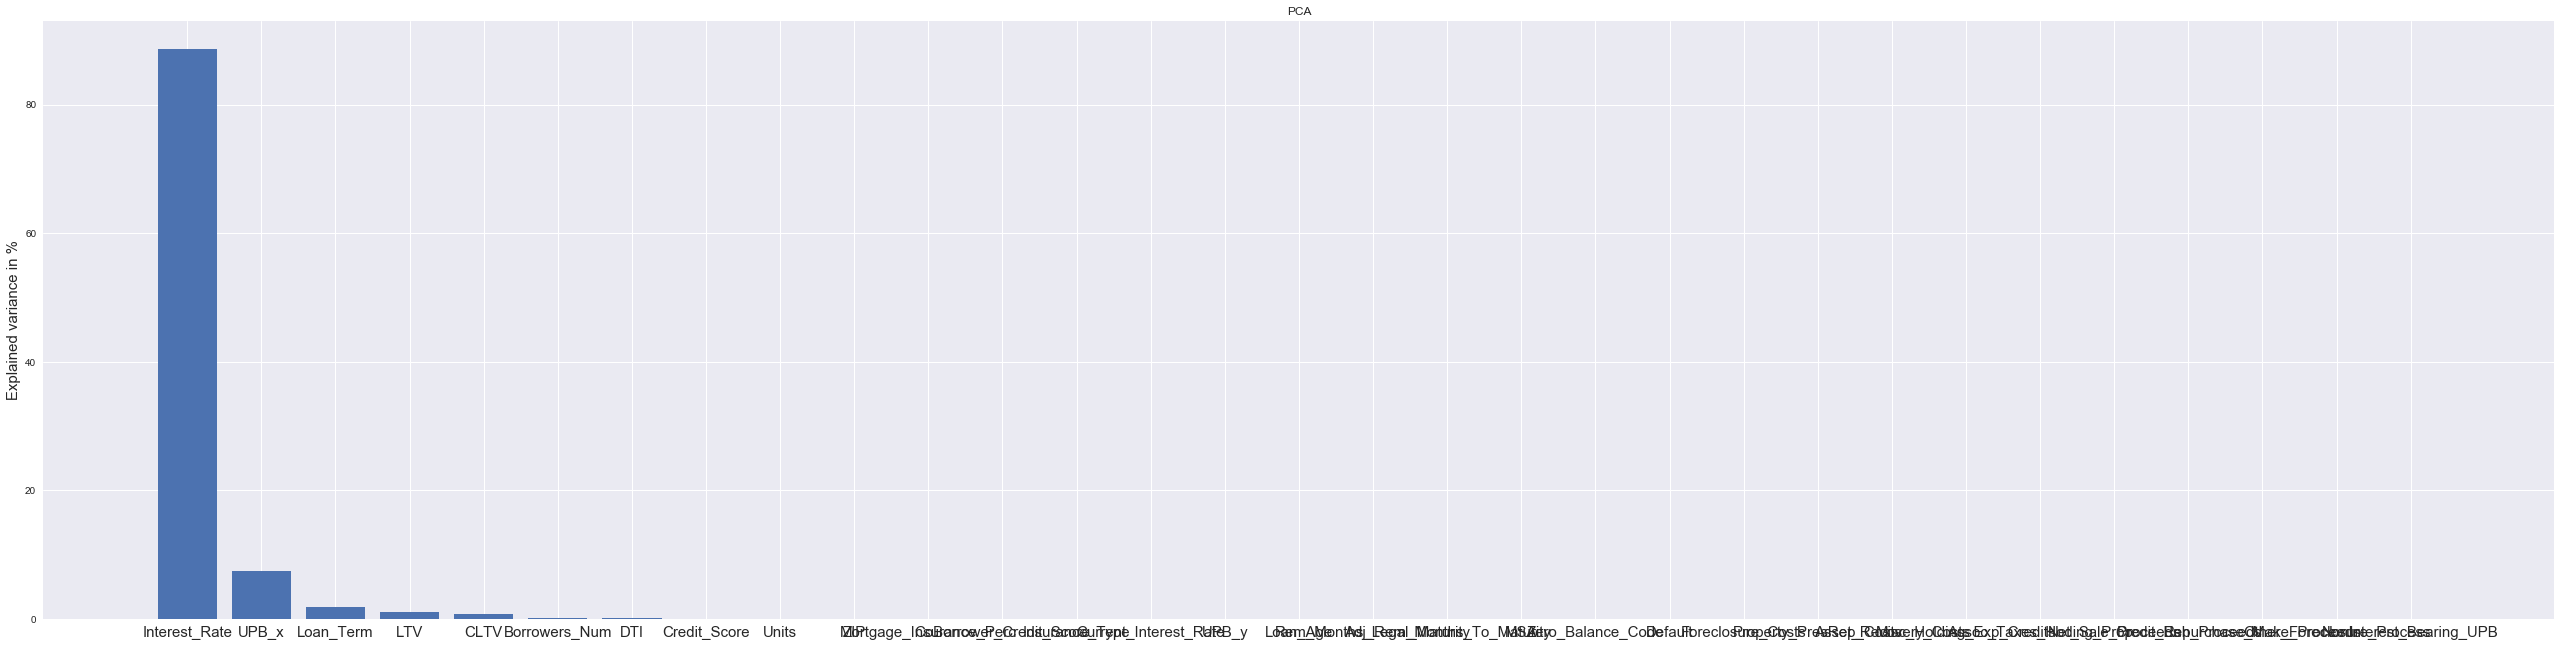

In [4]:
# Excluding features, where most of the information is missing
data.fillna(0, inplace=True) #filling missing variables with 0 (better approaches if the data is smaller or if more powerfull machine is used for processing it)
data.drop(['ID_Loan','First_Time_Buyer','Seller_Name','Chanel_Org','Date_Origination','First_Payment_Date','Loan_Purpose','Property_Type','Occupancy_Status','State','Product_Type','Reloc_Indicator','Monthly_Rep_Period','Service_Name','Maturity_Date','Current_Loan_Deliquency_Status','Modification_Flag','Zero_Balance_Date','Last_Paid_Installment_Date','Disposition_Date','Principal_Forgiveness_UPB','Repurchase_Make_Proceeds_Flag','Foreclosure_Princ_WriteOff','Servicing_Activity_Indicatior'], axis=1, inplace=True)
#PCA starts 
scaled_data = pd.DataFrame(preprocessing.scale(data),columns = data.columns) 
pca = PCA()
pca.fit(data)
pca_data = pca.transform(data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = data.columns

x=range(1,len(per_var)+1)

plt.bar(x, height=per_var, tick_label=labels)
plt.title('PCA')
plt.ylabel('Explained variance in %', fontsize=15)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(45, 11)
fig.savefig('test.png', dpi=300)
plt.xticks(fontsize=15)

plt.show()

#PCA end

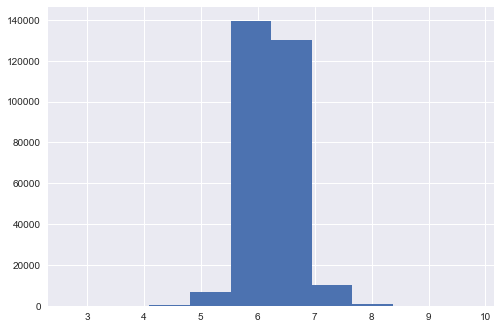

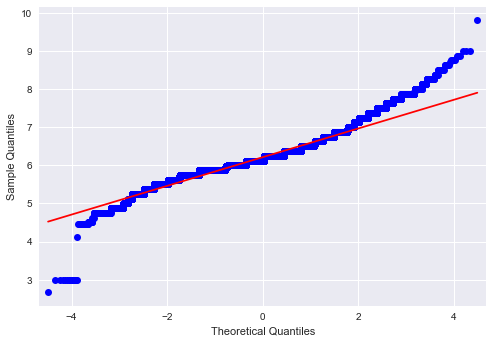

In [5]:
# Checking the distrubtion of the most important features

plt.hist(data['Interest_Rate'])
plt.show()

qqplot(data['Interest_Rate'], line='s')
plt.show()

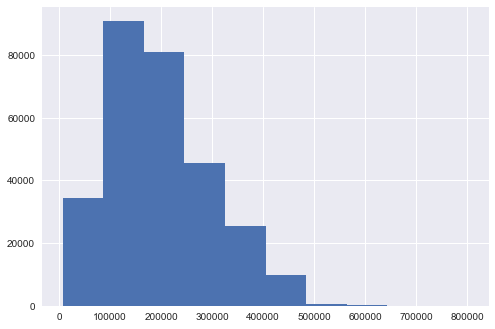

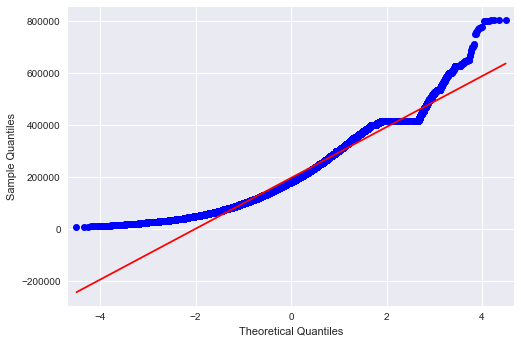

In [6]:
plt.hist(data['UPB_x'])
plt.show()

qqplot(data['UPB_x'], line='s')
plt.show()

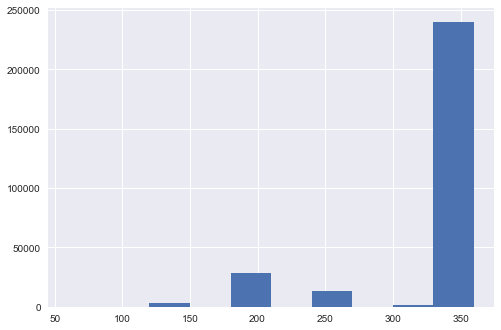

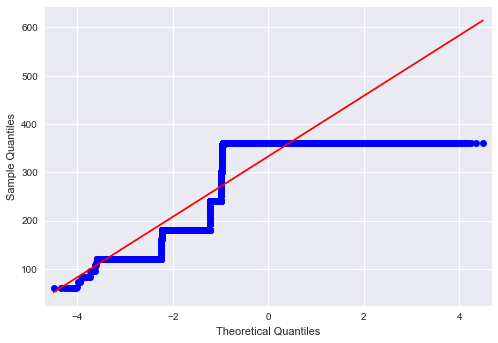

In [7]:
plt.hist(data['Loan_Term'])
plt.show()

qqplot(data['Loan_Term'], line='s')
plt.show()

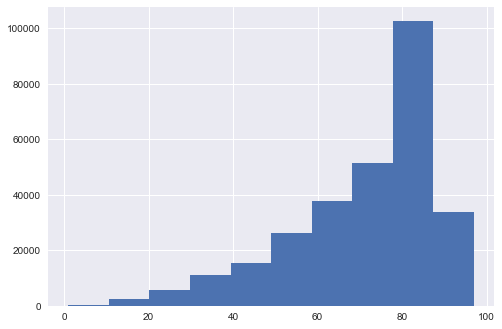

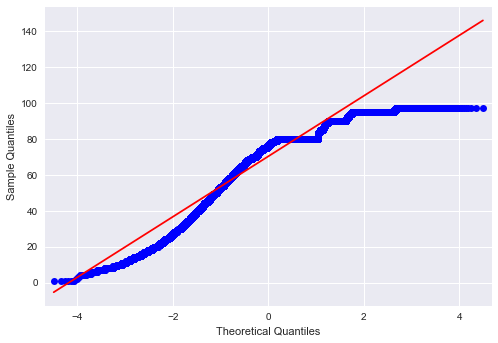

In [8]:
plt.hist(data['LTV'])
plt.show()

qqplot(data['LTV'], line='s')
plt.show()

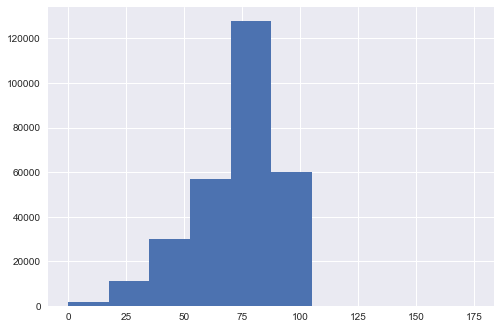

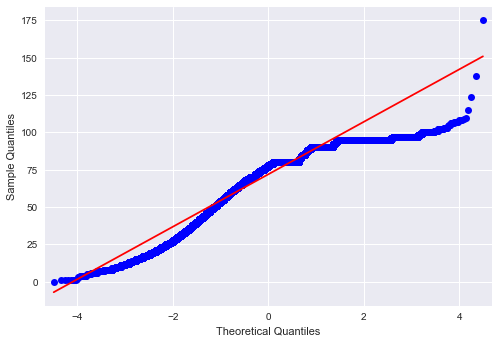

In [9]:
plt.hist(data['CLTV'])
plt.show()

qqplot(data['CLTV'], line='s')
plt.show()

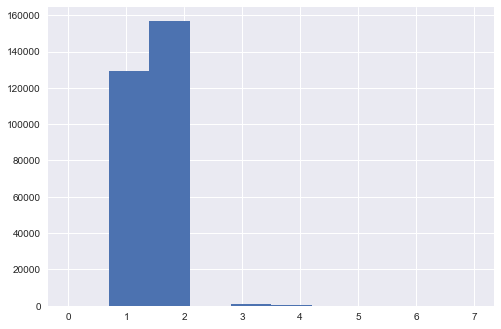

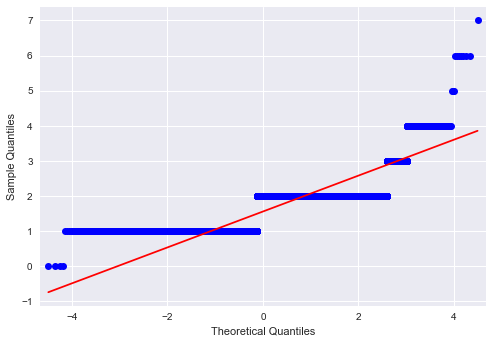

In [10]:
plt.hist(data['Borrowers_Num'])
plt.show()

qqplot(data['Borrowers_Num'], line='s')
plt.show()

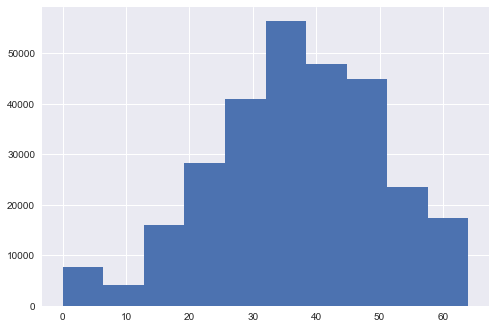

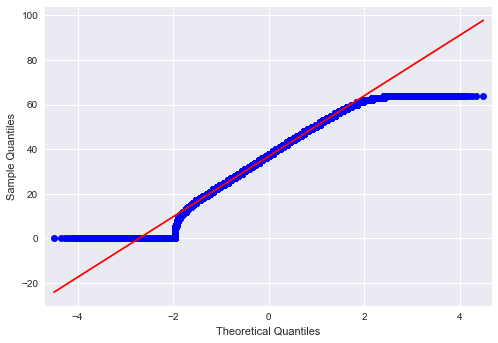

In [11]:
plt.hist(data['DTI'])
plt.show()

qqplot(data['DTI'], line='s')
plt.show()

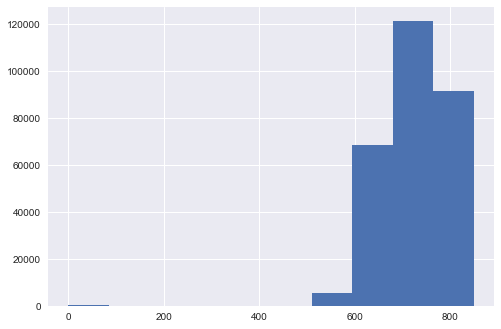

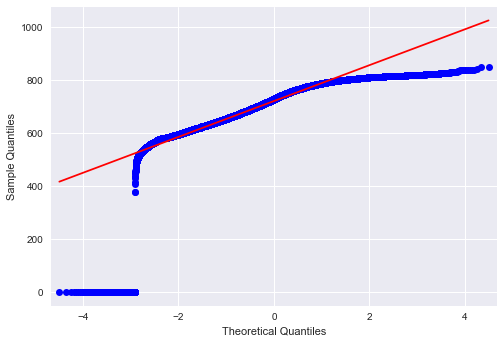

In [12]:
plt.hist(data['Credit_Score'])
plt.show()

qqplot(data['Credit_Score'], line='s')
plt.show()

### (Ref: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)

In [13]:
#Dropping features with more than 70% missing variables
data.drop(['Zero_Balance_Code','MSA','Adj_Rem_Months_To_Maturity','Mortgage_Insurance_Perc','Units', 'CoBorrower_Credit_Score', 'ZIP', 'Loan_Age', 'UPB_y', 'Rem_Months_Legal_Maturity','Insurance_Type', 'Current_Interest_Rate'], axis=1, inplace=True)
# Dropping
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
#End of dropping features

In [14]:
sm = SMOTEENN()
y = data['Default'].values
X = data.drop(['Default'], axis=1).values
# ref http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_enn.html

X_resampled, y_resampled = sm.fit_sample(X, y)
scaled_data = preprocessing.minmax_scale(X_resampled, feature_range=(0, 1)) #scaling the x valued to lower the std

In [15]:
k=10
kf = KFold(n_splits = k)
for train,test in kf.split(X_resampled):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]


IndexError: index 287275 is out of bounds for axis 0 with size 287275

In [18]:
## K-Fold cross validation
k=10
kf = KFold(n_splits = k)
for train,test in kf.split(X_resampled):
    X_train, X_test, y_train, y_test = X_resampled[train], X_resampled[test], y_resampled[train], y_resampled[test]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y_resampled, test_size = 0.3)

In [20]:
##### Naive Bayes #####

NB = GaussianNB()
NB.fit(X_train, y_train)
predict_NB = NB.predict(X_test)

print("Accuracy with test data:", metrics.accuracy_score(y_test, predict_NB))
print(classification_report(y_test, predict_NB))

Accuracy with test data: 0.7454667968243821
             precision    recall  f1-score   support

          0       0.82      0.55      0.66     51775
          1       0.71      0.91      0.80     63982

avg / total       0.76      0.75      0.74    115757



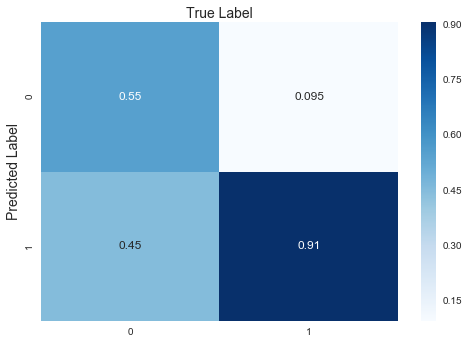

In [21]:
# NB confusion matrix 
cm = confusion_matrix(y_test, predict_NB).T
cm = cm.astype('float')/cm.sum(axis=0)
fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label', fontsize=14)
ax.set_ylabel('Predicted Label', fontsize=14)
ax.xaxis.set_label_position('top')
mp.show()

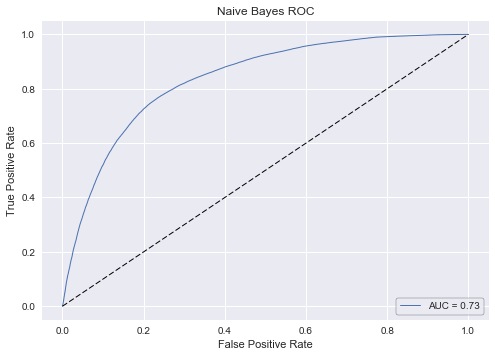

In [22]:
###  NB ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, NB.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict_NB)
mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=1)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.title('Naive Bayes ROC')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

In [23]:
# NB Error  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict_NB))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict_NB)))  

Mean Absolute Error: 0.2545332031756179
Root Mean Squared Error: 0.5045128374735551


In [24]:
##### SVM #####
svc = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=1)
svc.fit(X_train[:100000], y_train[:100000])
#svc.score(X_train, y_train)
predict_svc = svc.predict(X_test)
print("Accuracy with test data:", metrics.accuracy_score(y_test, predict_svc))
print(classification_report(y_test, predict_svc))

Accuracy with test data: 0.7919607453544926
             precision    recall  f1-score   support

          0       0.83      0.67      0.74     51775
          1       0.77      0.89      0.83     63982

avg / total       0.80      0.79      0.79    115757



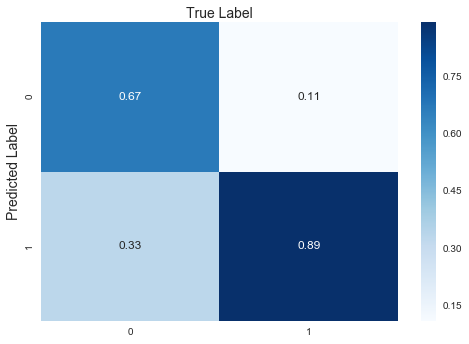

In [25]:
# SVM confusion matrix 
cm = confusion_matrix(y_test, predict_svc).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label', fontsize=14)
ax.set_ylabel('Predicted Label', fontsize=14)
ax.xaxis.set_label_position('top')
mp.show()

In [30]:
# SVM Error  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict_svc))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict_svc)))  

Mean Absolute Error: 0.2080392546455074
Root Mean Squared Error: 0.45611320376142084


In [33]:
##### Decision Tree #####
DT_classifier = DecisionTreeClassifier()  
DT_classifier.fit(X_train, y_train)
predict_DT = DT_classifier.predict(X_test) 

print("Accuracy with test data:", metrics.accuracy_score(y_test, predict_DT))
print(classification_report(y_test, predict_DT))

Accuracy with test data: 0.9111328040636851
             precision    recall  f1-score   support

          0       0.91      0.89      0.90     51775
          1       0.92      0.92      0.92     63982

avg / total       0.91      0.91      0.91    115757



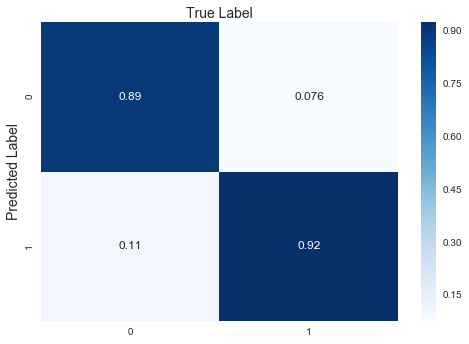

In [34]:
# DT confusion matrix 
cm = confusion_matrix(y_test, predict_DT).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label', fontsize=14)
ax.set_ylabel('Predicted Label', fontsize=14)
ax.xaxis.set_label_position('top')
mp.show()

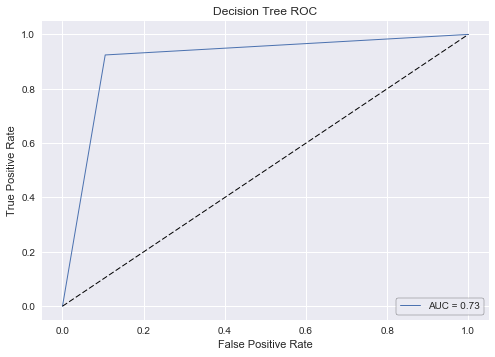

In [35]:
# DT ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, DT_classifier.predict_proba(X_test)[:,1])
dt_auc = roc_curve(y_test, predict_DT)
mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=1)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.title('Decision Tree ROC')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

In [36]:
# DT Error  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict_DT))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict_DT)))  


Mean Absolute Error: 0.08886719593631487
Root Mean Squared Error: 0.29810601459265273


In [37]:
##### RANDOM FOREST #####

rand_forest = RandomForestClassifier(n_estimators=60)
rand_forest = rand_forest.fit(X_train, y_train)

predict_RF = rand_forest.predict(X_test)
print("Accuracy with test data:",metrics.accuracy_score(y_test, predict_RF))
print(classification_report(y_test, predict_RF))


Accuracy with test data: 0.9396321604740966
             precision    recall  f1-score   support

          0       0.92      0.95      0.93     51775
          1       0.96      0.93      0.94     63982

avg / total       0.94      0.94      0.94    115757



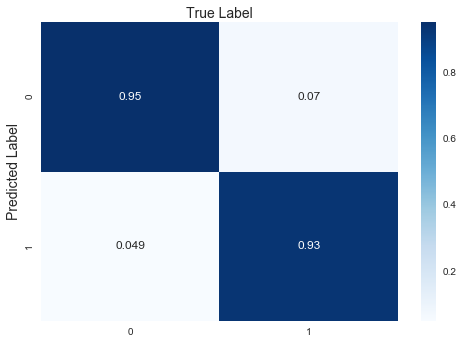

In [40]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, predict_RF).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label', fontsize=14)
ax.set_ylabel('Predicted Label', fontsize=14)
ax.xaxis.set_label_position('top')
mp.show()

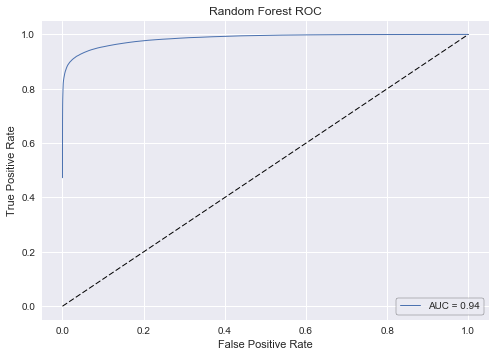

In [43]:
# % Of the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rand_forest.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict_RF)
mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=1)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.title('Random Forest ROC')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

In [44]:
# Fandom Forest Error 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict_RF))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict_RF)))  

Mean Absolute Error: 0.060367839525903404
Root Mean Squared Error: 0.2456986762803239
